In [1]:
import os
import sys
import tarfile
import urllib.request
from urllib.error import URLError, HTTPError

def download_file(url: str, dest_path: str, chunk_size: int = 8192) -> None:
    """
    Download a file from `url` to `dest_path`, showing a simple progress indicator.
    Skips download if file already exists.
    """
    if os.path.exists(dest_path):
        print(f"[SKIP] '{dest_path}' already exists.")
        return

    try:
        with urllib.request.urlopen(url) as response:
            total_size = response.getheader('Content-Length')
            total_size = int(total_size) if total_size else None
            downloaded = 0

            with open(dest_path, 'wb') as out_file:
                while True:
                    chunk = response.read(chunk_size)
                    if not chunk:
                        break
                    out_file.write(chunk)
                    downloaded += len(chunk)
                    if total_size:
                        percent = downloaded / total_size * 100
                        print(f"\rDownloading {os.path.basename(dest_path)}: {percent:5.1f}%", end="")
            print("\n[OK] Download complete.")

    except HTTPError as e:
        print(f"\n[ERROR] HTTP {e.code}: {e.reason} for {url}")
        sys.exit(1)
    except URLError as e:
        print(f"\n[ERROR] URL error: {e.reason} for {url}")
        sys.exit(1)

def extract_tar(file_path: str, extract_to: str) -> None:
    """
    Extracts `file_path` (must be a tar archive) into directory `extract_to`.
    """
    if not tarfile.is_tarfile(file_path):
        print(f"[ERROR] '{file_path}' is not a valid tar archive.")
        sys.exit(1)

    with tarfile.open(file_path, 'r') as tar:
        tar.extractall(path=extract_to)
    print(f"[OK] Extracted '{os.path.basename(file_path)}' → '{extract_to}/'")

def main():
    base_url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012"
    archives = [
        "VOCtrainval_11-May-2012.tar",  # images and annotations for train+val 2012
        # "VOCtest_06-Nov-2007.tar"       # test 2007 set (often used for legacy tests)
    ]

    download_dir = "downloads"
    extract_dir = "VOCdevkit"

    # Create target directories
    os.makedirs(download_dir, exist_ok=True)
    os.makedirs(extract_dir, exist_ok=True)

    for archive in archives:
        url = f"{base_url}/{archive}"
        dest_path = os.path.join(download_dir, archive)

        print(f"\n→ Processing '{archive}'")
        download_file(url, dest_path)
        extract_tar(dest_path, extract_dir)

    print("\nAll done! Your VOC data is in the 'VOCdevkit/' directory.")

main()


→ Processing 'VOCtrainval_11-May-2012.tar'
[OK] Download complete.
[OK] Extracted 'VOCtrainval_11-May-2012.tar' → 'VOCdevkit/'

All done! Your VOC data is in the 'VOCdevkit/' directory.


In [6]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

def parse_voc_filtered(annotation_dir, split_list_path):
    """
    Parse VOC annotations, only including files listed in the given split (dev.txt).
    """
    # Step 1: Read the allowed filenames from dev.txt
    with open(split_list_path, 'r') as file:
        valid_filenames = set(line.strip() + '.xml' for line in file)

    records = []

    for annotation_file in os.listdir(annotation_dir):
        if annotation_file not in valid_filenames:
            continue  # Skip files not listed in dev.txt

        tree = ET.parse(os.path.join(annotation_dir, annotation_file))
        root = tree.getroot()

        file_name = root.find('filename').text
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        for obj in root.findall('object'):
            class_name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))

            records.append({
                'filename': file_name,
                'width': width,
                'height': height,
                'class': class_name,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax
            })

    df = pd.DataFrame(records)
    return df

annotation_dir = "/content/VOCdevkit/VOCdevkit/VOC2012/Annotations"  # Annotation directory
split_list_path = "/content/dev.txt"  # Path to your dev.txt file

df = parse_voc_filtered(annotation_dir, split_list_path)

print(f"Loaded {len(df)} object annotations from dev.txt split.")
df.head()

Loaded 3157 object annotations from dev.txt split.


,filename,width,height,class,xmin,ymin,xmax,ymax
0,2009_002236.jpg,500,375,chair,253,231,421,375
1,2009_002236.jpg,500,375,chair,361,289,500,375
2,2010_000806.jpg,500,281,motorbike,118,109,338,267
3,2010_000806.jpg,500,281,person,190,69,293,234
4,2008_007511.jpg,500,291,sofa,15,17,489,268


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from tqdm import tqdm

# Unique images
unique_images = df['filename'].nunique()
print(f"Total unique images: {unique_images}")

# Total entries
total = len(df)
print(f"Total annotated objects: {total}")

all = set(os.listdir("/content/VOCdevkit/VOCdevkit/VOC2012/JPEGImages"))
annotated_img = set(df['filename'].unique())

missing_annot = all - annotated_img
print(f"Images without annotations: {len(missing_annot)}")

# Bounding Boxes Inside Image Dimensions

def check_bboxes(df):
    bad_boxes = df[
        (df['xmin'] < 0) | (df['ymin'] < 0) |
        (df['xmax'] > df['width']) | (df['ymax'] > df['height']) |
        (df['xmin'] >= df['xmax']) | (df['ymin'] >= df['ymax'])
    ]
    return bad_boxes

bad_boxes = check_bboxes(df)
print(f"Bounding boxes out of bounds: {len(bad_boxes)}")

# Duplicate Filenames

duplicate_files = df['filename'].duplicated().sum()
print(f"Duplicated file names): {duplicate_files}")

Total unique images: 1136
Total annotated objects: 3157
Images without annotations: 15989
Bounding boxes out of bounds: 0
Duplicated file names): 2021


**Total unique images:** 1,136

**Total annotated objects:** 3,157

**Images without annotations:** 15,989

**Bounding boxes out of bounds:** 0

**Duplicate filenames:** 2,021<br>

The dataset exhibits no invalid bounding boxes, although a significant number of images lack annotations. These insights ensure the reliability of the annotated subset for subsequent modeling tasks.<Br><br>

**Total Unique Images:** determined how many distinct picture filenames were included in the DataFrame annotation.<BR>
**Total Annotated Objects:** determined how many bounding box entries there were in each picture (per item annotation).<br>
**Images without Annotations:** Compared all available images in the dataset directory against the annotated ones to find images that have no corresponding annotation.<br>
**Bounding Box Validation:** Checked if any bounding boxes are invalid, such as:<br>
* Coordinates being negative

* Bounding box limits exceeding the image dimensions

* Bounding boxes where xmin ≥ xmax or ymin ≥ ymax<br>

**Duplicate Filenames:** found the number of photos with numerous object annotations (i.e., with the same filename appearing in several entries).<br>


Object counts per class:
class
person         1038
chair           290
car             245
bottle          176
dog             152
cat             125
boat            116
bird            100
pottedplant      91
aeroplane        88
bicycle          83
tvmonitor        83
horse            82
diningtable      82
sofa             78
sheep            76
train            71
motorbike        67
bus              57
cow              57
Name: count, dtype: int64


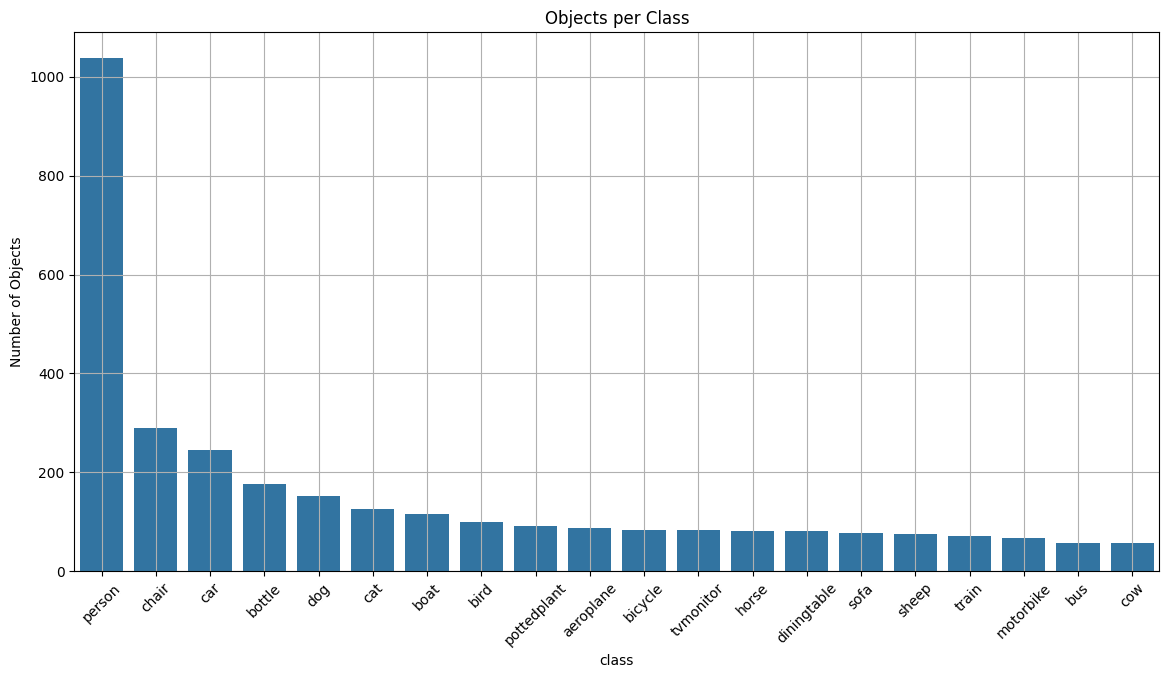

Class imbalance ratio (max/min): 18.21


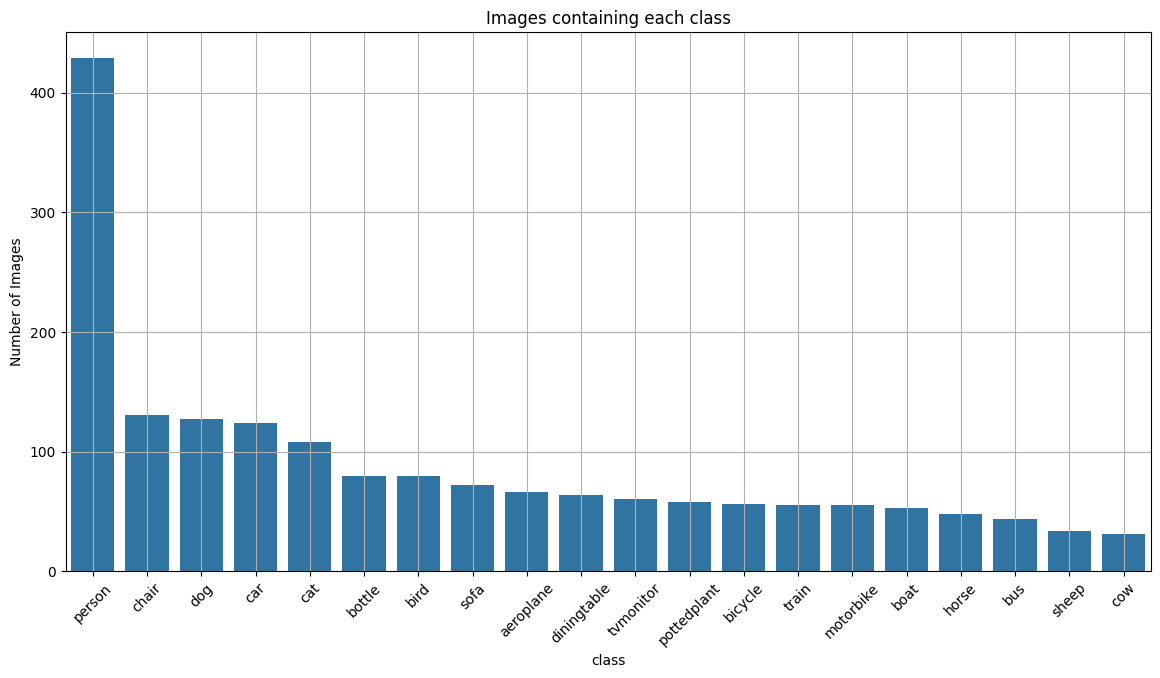

Images with multiple classes: 451
Images with single class: 685


In [8]:
# No. of objects per class
classes = df['class'].value_counts()
print("Object counts per class:")
print(classes)

plt.figure(figsize=(14,7))
sns.barplot(x=classes.index, y=classes.values)
plt.title('Objects per Class')
plt.xticks(rotation=45)
plt.ylabel('Number of Objects')
plt.grid(True)
plt.show()

max_class = classes.max()
min_class = classes.min()
imbalance_ratio = max_class / min_class
print(f"Class imbalance ratio (max/min): {imbalance_ratio:.2f}")

# Images in a class
images_per_class = df.groupby('class')['filename'].nunique().sort_values(ascending=False)
plt.figure(figsize=(14,7))
sns.barplot(x=images_per_class.index, y=images_per_class.values)
plt.title('Images containing each class')
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()

image_classes = df.groupby('filename')['class'].nunique()

multi_classes = (image_classes > 1).sum()
single_classes = (image_classes == 1).sum()

print(f"Images with multiple classes: {multi_classes}")
print(f"Images with single class: {single_classes}")


**Object Counts per Class:** Combined, there are 3,157 labeled items in 20 classes in the set.  The most common item and the most pervasive class is 'person' occurring 1,038 times.  'chair' (290 times) and 'vehicle' (245 times) are among the other recurring classes.
The less common classes, including "bus" and "cow," each occur only 57 times and suggest that they are not represented as well.<br>
**Class Imbalance:** The ratio of the approximate maximum to minimum object value of 18.21 indicates a seeming imbalance in the class.  Based from the size of objects in the densest class ('human') to the spares ones ('bus' and 'cow'), this value was taken.  If not well balanced through methods like resampling, loss weighting, or data augmentation, it can cause biased model training towards majority classes.<br>
**Images per Class:** We also looked at how many distinct pictures had at least one item from each class.  Once more, the class 'human' has the most photos, followed by 'chair', 'dog' and 'vehicle'.
 This suggests that uncommon classes are restricted to fewer photographs, whilst certain classes are more extensively dispersed throughout many images.<br>
**Single vs. Multiple Class Images:** By examining the number of distinct classes per image:<Br>
* 451 images were found to contain multiple object classes, indicating more complex scenes.<Br>
* 685 images contained only a single object class, suggesting simpler scenes with less contextual variety.<Br><br>

**Observations and Considerations:**<Br>

* Because of the dominance of some classes, a model may perform badly on underrepresented classes while achieving better accuracy for these classes.<br>
* Balancing techniques such as oversampling minority classes, undersampling majority classes, or using class-balanced loss functions should be considered during training.<br>


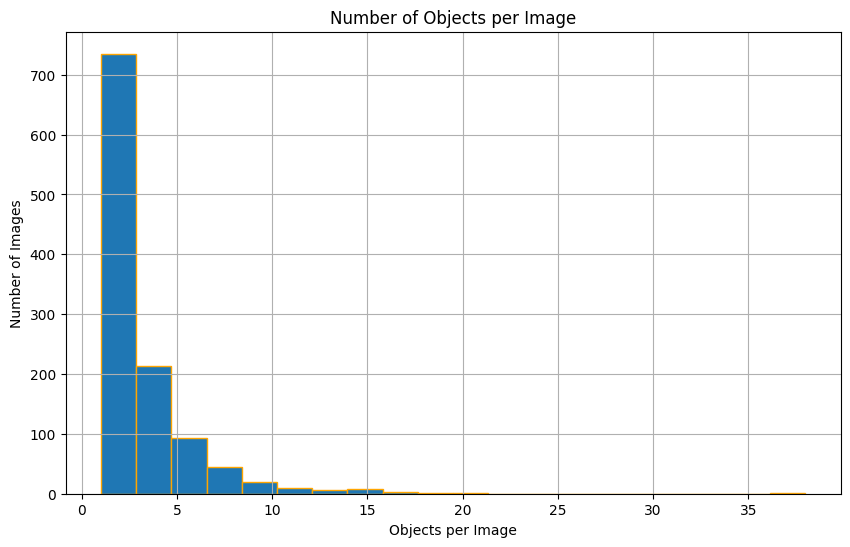

Percentage of images with more than 5 objects: 16.46%


In [9]:
#Objects in a image
obj_img = df.groupby('filename').size()

plt.figure(figsize=(10,6))
plt.hist(obj_img, bins=20, edgecolor='orange')
plt.title('Number of Objects per Image')
plt.xlabel('Objects per Image')
plt.ylabel('Number of Images')
plt.grid(True)
plt.show()

#Cumulative distribution
cum = (obj_img >= 5).sum() / len(obj_img)
print(f"Percentage of images with more than 5 objects: {cum*100:.2f}%")

**Object Density per Image:**

 Analyzing the distribution of objects across images to understand image complexity:<Br><br>

**Distribution Analysis:**
To demonstrate the number of items in each photo, a histogram was provided.  The majority of photos have one to three items, and the frequency of items decreases rapidly as the number of items rises.
Though unusual, a small percentage of images have a very large number of objects (more than 15 objects).<br>

**Important note:**
* The majority of the images contain relatively few objects, suggesting that many images depict simple scenes with isolated or few entities.
<Br>
* The percentage of images containing more than 5 objects was calculated to be 16.46%.This indicates that roughly one-sixth of the dataset involves complex scenes with multiple objects.
<Br>

**Observations and Implications:**

* When models meet complicated, packed scenarios during testing or deployment, datasets that are mostly composed of simpler pictures may cause them to perform poorly.
* To make sure the model learns to handle photos with increased item density efficiently, extra care should be given during training (for example, by using data augmentation or hard example mining).


Number of Objects Per Image

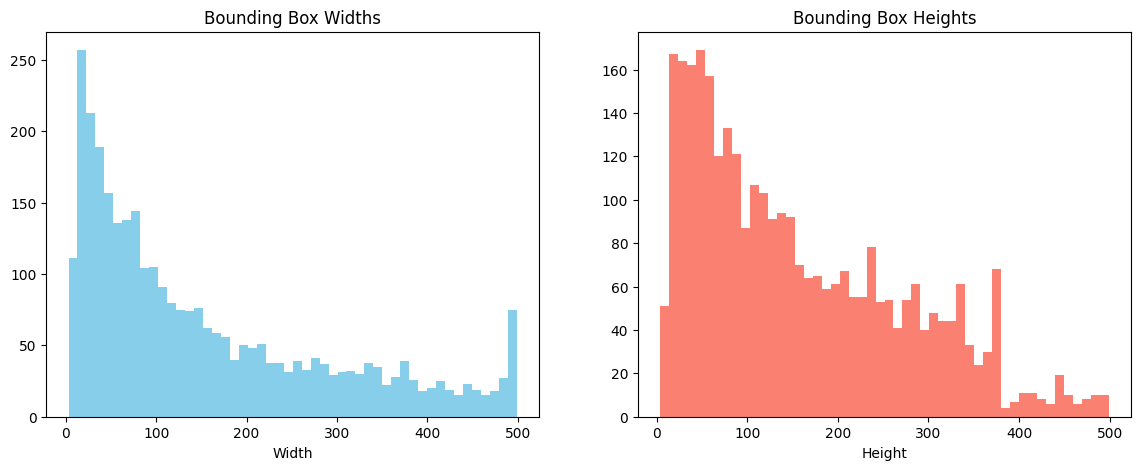

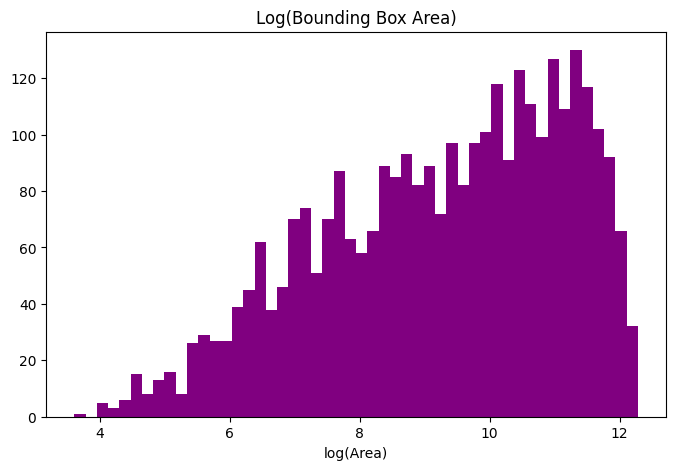

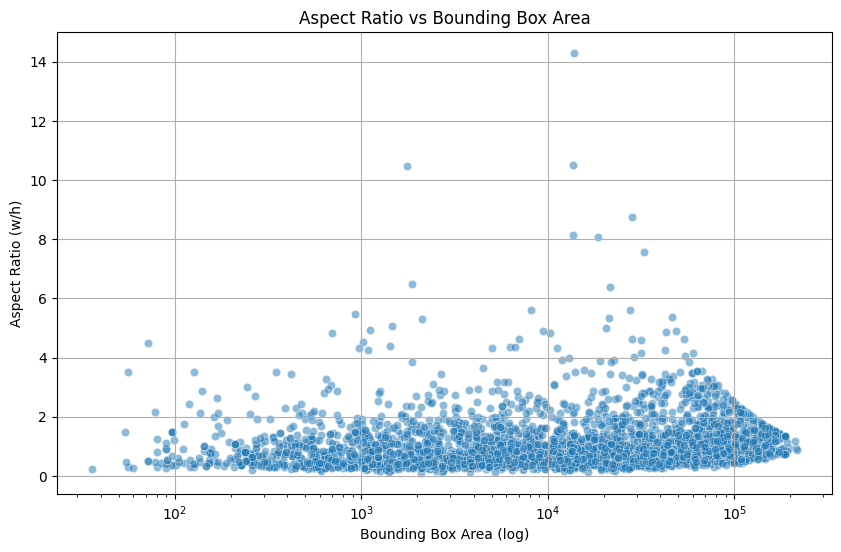

size_bucket
medium    1636
large      884
small      637
Name: count, dtype: int64


In [10]:
# Absolute bbox sizes

df['bbox_width'] = df['xmax'] - df['xmin']
df['bbox_height'] = df['ymax'] - df['ymin']
df['bbox_area'] = df['bbox_width'] * df['bbox_height']

# Width and height histograms
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(df['bbox_width'], bins=50, color='skyblue')
plt.title('Bounding Box Widths')
plt.xlabel('Width')

plt.subplot(1,2,2)
plt.hist(df['bbox_height'], bins=50, color='salmon')
plt.title('Bounding Box Heights')
plt.xlabel('Height')
plt.show()

# Log area histogram
plt.figure(figsize=(8,5))
plt.hist(np.log1p(df['bbox_area']), bins=50, color='purple')
plt.title('Log(Bounding Box Area)')
plt.xlabel('log(Area)')
plt.show()

# Aspect ratio
df['aspect_ratio'] = df['bbox_width'] / df['bbox_height']

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='bbox_area', y='aspect_ratio', alpha=0.5)
plt.xscale('log')
plt.title('Aspect Ratio vs Bounding Box Area')
plt.xlabel('Bounding Box Area (log)')
plt.ylabel('Aspect Ratio (w/h)')
plt.grid(True)
plt.show()

# Relative Size (COCO-style small, medium, large)
df['img_area'] = df['width'] * df['height']
df['rel_area'] = df['bbox_area'] / df['img_area']

def size_bucket(rel_area):
    if rel_area < 0.01:
        return 'small'
    elif rel_area < 0.25:
        return 'medium'
    else:
        return 'large'

df['size_bucket'] = df['rel_area'].apply(size_bucket)

print(df['size_bucket'].value_counts())

**Bounding Box Size, Area, and Aspect Ratio Analysis**
<br><br>

 Exploring the geometric properties of the bounding boxes in the dataset to better understand object sizes, shapes, and distribution:<br>

**Bounding Box Widths and Heights:**

* Most widths and heights of bounding boxes are concentrated below 100 pixels, making them comparatively short and narrow.

* A long tail distribution exists, indicating a few extremely large bounding boxes, particularly towards 400–500 pixels.

**Bounding Box Areas (Log Scale):**

* A skewed distribution, with smaller portions in the majority of the enclosing boxes.
* The frequency of larger bounding boxes (with high area) is much lower.
* By stabilizing the spread, using the logarithm makes it easier to see the vast array of regions.

**Aspect Ratio (Width/Height):**

* Most objects have an aspect ratio between 0.5 and 2, meaning they are not extremely elongated.
* Although they are uncommon, extremely high aspect ratios can be found and are frequently associated with either extremely thin objects or annotation mistakes.

**Relative Size Categories (COCO-style Buckets):**

* Small objects: Bounding box area < 1% of the image area (637 objects).
* Medium objects: Bounding box area between 1% and 25% of the image area (1,636 objects).
* Large objects: Bounding box area > 25% of the image area (884 objects).

**Observations and Implications:**

* Although there are a fair amount of little and large objects in the collection, medium-sized objects predominate.
* Given the large range of item sizes, multi-scale detection techniques (such as feature pyramid networks and picture pyramids) may be very useful.
* Since tiny items are usually more difficult for models to learn, care should be made to ensure they are recognized accurately during model training.

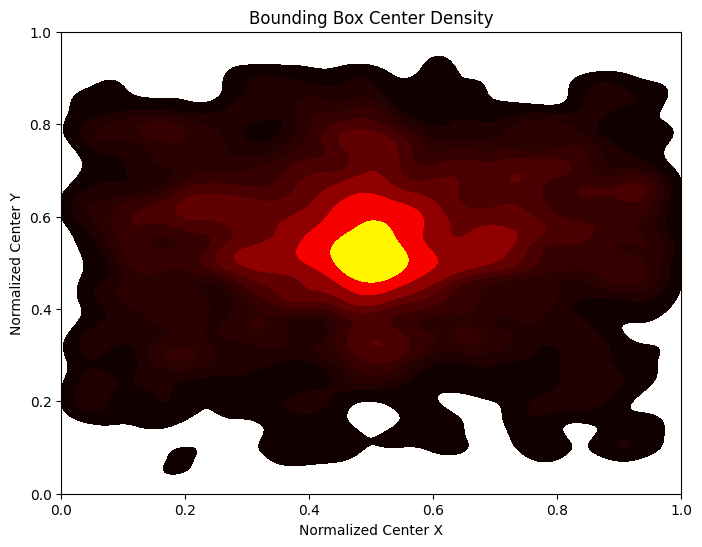

In [11]:
import plotly.express as px
# Center heatmap
df['center_x'] = (df['xmin'] + df['xmax']) / 2 / df['width']
df['center_y'] = (df['ymin'] + df['ymax']) / 2 / df['height']

plt.figure(figsize=(8,6))
sns.kdeplot(x=df['center_x'], y=df['center_y'], cmap='hot', fill=True, bw_adjust=0.5)
plt.title('Bounding Box Center Density')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Normalized Center X')
plt.ylabel('Normalized Center Y')
plt.show()

# Class co-occurrence matrix
from sklearn.preprocessing import MultiLabelBinarizer

# Create a set of classes per image
image_classes = df.groupby('filename')['class'].apply(set)
mlb = MultiLabelBinarizer()
class_matrix = mlb.fit_transform(image_classes)

co_occurrence = np.dot(class_matrix.T, class_matrix)

fig = px.imshow(co_occurrence,
                labels=dict(x="Class", y="Class", color="Co-occurrence"),
                x=mlb.classes_,
                y=mlb.classes_,
                title="Class Co-occurrence Matrix")
fig.show()


**Spatial Distribution and Class Co-occurrence Analysis**
<br>

 Exploring the spatial arrangement of bounding boxes and the co-occurrence patterns between object classes:

**Bounding Box Center Density:**
<br>
We normalized the bounding box centers relative to their image width and height and plotted a 2D Kernel Density Estimate (KDE) heatmap:
<br>
* Bounding box centers are highly clustered close to the picture center, as the heatmap illustrates.
* The progressive decline toward the edges suggests that the majority of annotated items are found in the image's core area.
* Model performance may be impacted by this spatial bias, which could lead models to anticipate item existence closer to the center rather than the perimeter.
<br>

**Class Co-occurrence Matrix:**
<br>
A class co-occurrence matrix was generated by analyzing the combinations of object classes present within the same images:<Br>
* As may be predicted, the strongest entries are the diagonal ones (self-co-occurrence), which indicate pictures with several examples of the same class.
* Images where several distinct classes coexist are indicated by off-diagonal components.
* Some combinations, such "person" and "bicycle," "person" and "motorbike," and "sofa" and "pottedplant," have comparatively greater co-occurrence, indicating that the dataset contains common contextual groupings.
<br><br>

**Observations and Implications:**
<br>
* Models can enhance detection performance by taking use of the geographical and contextual links between classes, particularly when employing techniques like relation modules or context modeling.
* While evaluating the model, it should be ensured that the center bias is remembered, especially while testing on datasets that have mixed scene composition (such as surveillance or aerial scenes, where objects might not be center-aligned).

In [12]:
import cv2

means = []
stds = []

sample_images = df['filename'].unique()[:300]

for img_name in tqdm(sample_images):
    img_path = os.path.join("/content/VOCdevkit/VOCdevkit/VOC2012/JPEGImages/", img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    means.append(np.mean(img, axis=(0,1)))
    stds.append(np.std(img, axis=(0,1)))

mpc = np.mean(means, axis=0)
std_pc = np.mean(stds, axis=0)

print(f"Mean per channel [R,G,B]: {mpc}")
print(f"Std per channel [R,G,B]: {std_pc}")

100%|██████████| 300/300 [00:08<00:00, 36.52it/s]

Mean per channel [R,G,B]: [116.54052319 111.69363542 102.81330511]
Std per channel [R,G,B]: [60.72291842 59.89243166 60.86780944]


**Image Normalization Statistics (Mean and Standard Deviation per Channel)**
<br>
To prepare for model training, we computed the mean and standard deviation for each RGB color channel across a random sample of 300 images from the dataset:<BR>
Mean pixel values per channel [R, G, B]:

[
116.54
,
111.69
,
102.81
]
<br>

Standard deviation per channel [R, G, B]:

[
60.72
,
59.89
,
60.86
]
<Br><br>

Note:<br>
* Each image was loaded using OpenCV and converted from BGR to RGB format.
* After calculating the mean and standard deviation for each image, the average was calculated for all of the sampled photographs.
<br>

**Observations and Implications:**

* The computed mean and standard deviation can be used to normalize the images during preprocessing (subtract the mean and divide by the standard deviation for each channel).
* Because normalization guarantees that the input data is centered and scaled, it facilitates faster and more stable model convergence during training.
* Despite the Red channel's somewhat greater intensity than the Green and Blue channels, the values indicate that the dataset's color channels are generally well-balanced.

In [13]:
from itertools import combinations
import cv2
# Zero-area boxes
zero_area = df[(df['bbox_width'] <= 0) | (df['bbox_height'] <= 0)]
print(f"Zero-area bounding boxes: {len(zero_area)}")

# Boxes outside image bounds
out_of_bounds = df[
    (df['xmin'] < 0) | (df['ymin'] < 0) |
    (df['xmax'] > df['width']) | (df['ymax'] > df['height'])
]
print(f"Boxes outside image bounds: {len(out_of_bounds)}")

# Highly overlapping boxes (IoU > 0.9)

def iou(box1, box2):
    x1 = max(box1['xmin'], box2['xmin'])
    y1 = max(box1['ymin'], box2['ymin'])
    x2 = min(box1['xmax'], box2['xmax'])
    y2 = min(box1['ymax'], box2['ymax'])

    inter_area = max(0, x2-x1) * max(0, y2-y1)
    area1 = (box1['xmax'] - box1['xmin']) * (box1['ymax'] - box1['ymin'])
    area2 = (box2['xmax'] - box2['xmin']) * (box2['ymax'] - box2['ymin'])

    union = area1 + area2 - inter_area
    if union== 0:
        return 0
    return inter_area / union
iou_pairs = []

for img_name, group in tqdm(df.groupby('filename')):
    boxes = group.to_dict('records')
    for box1, box2 in combinations(boxes, 2):
        if box1['class'] == box2['class']:
            if iou(box1, box2) > 0.9:
                iou_pairs.append((img_name, box1, box2))

print(f"Overlapping same-class boxes: {len(iou_pairs)}")


Zero-area bounding boxes: 0
Boxes outside image bounds: 0


100%|██████████| 1136/1136 [00:01<00:00, 770.58it/s]

Overlapping same-class boxes: 0


**Bounding Box Quality Checks**
<br>
performing several checks to validate the integrity and correctness of the bounding box annotations:<br><Br>
Zero-area Bounding Boxes:<br>
* Zero-width and zero-height bounding boxes were examined.
* Result: 0 zero-area bounding boxes were found, indicating all boxes have valid dimensions.
<bR>

Bounding Boxes Outside Image Bounds:<Br>
* We verified that all bounding box coordinates are within the corresponding image dimensions (i.e., xmin ≥ 0, ymin ≥ 0, xmax ≤ width, ymax ≤ height).

* Result: 0 bounding boxes were found outside their respective image bounds, showing that spatial annotations are properly constrained.
<br>
Highly Overlapping Same-Class Boxes (IoU > 0.9):<Br>
* For each picture, we calculated the Intersection over Union (IoU) between pairs of boxes in the same class.<Br>
* A pair is considered highly overlapping if their IoU exceeds 0.9.<Br>
* Result: 0 highly overlapping same-class bounding box pairs were found, suggesting that the dataset does not suffer from duplicate or redundant annotations of the same object.<Br>

**Observations and Implications:**

* These findings verify that there are no frequent annotation problems in the dataset, like duplicate bounding boxes, incorrectly positioned boxes, or invalid dimensions.
* The model can train without bias or confusion due to inconsistent annotations because to the excellent quality of the annotations.